# Kaggle - Titanic Survival Passengers Prediction 

This is my first Kaggle competition - <a herf="https://www.kaggle.com/c/titanic"> predict the survival passengers from the Titanic</a>. In this project, I have learned 
- Data processing with **numpy and pandas** 
    - understand different types of data 
    - work with missing values 
    - feature engineering 
- Data visiualization with **seaborn**
- Data prediction with **sklearn** 
    - decision tree 
    - kNN 
    - random forest
    - logistic regression
    - cross validation to determine the optimal approach 

The accuracy of my model is **85%** on dev set and **78%** on the final prediction set (<a herf=https://www.kaggle.com/jieyu7/competitions>check out my kaggle page</a>). Though I do find that simpler and easier feature engineering process gives a model with a higher accuracy. But the main goal of this project is to learn different techniques of data analysis. I will learn about the efficiency of different feature engineering methods in the next kaggle project. 

2020.05.31

        

# Load data 

In [1]:
## imports
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import os
from matplotlib import pyplot as plt

In [2]:
## load data 
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Understand the data 

In [3]:
print(train_df.info())
print('*'*50)
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  

## Remove unrelated columns 

The first step is to look at the data and remove any unrelated columns. Here only the `PassengerId` is unrelated and has no influence on the prediction.


1. `PassengerId` is removed from both the training and the test sets but saved as a seperate column for creating the submission file;  

In [4]:
PassengerId = test_df['PassengerId']

train_df = train_df.drop(['PassengerId'], axis = 1)
test_df = test_df.drop(['PassengerId'], axis = 1)

## Group features 

The second step is to find out the data type of each feature, and whether each feature has unique values or missing values. The following is a brief summary. This summary is a guidance of the following data processing steps. This guidance could be changed as my understanding of the data set gets deeper. 

**bold** : missing values <div>
*italic* : unique values

- numertical features (shown in numbers)
    1. Pclass
    2. **Age**
    3. SibSp
    4. Parch
    5. **Fare** 
    <div>
- categorical features (shown in letters) : convert to numbers and get dummies 
    1. Sex
    2. **Embarked**
    <div>
- alphanumerical/text features (shown in both letters and numbers) : engineering features 
    1. **Cabin**
    2. *Ticket*
    3. *Name*

    


# process the data 

To process the data, I start with the simpler tasks and continue with harder tasks. The steps are 
1. convert categorical values to numbers
2. work with missing values 
3. work with feature engineering 
4. convert categorical values to dummies 

I choose not to convert the categorical values to dummies at first because this would create too many columns that makes the visualization complex. <div>
Before working on the data. I combine the `train_df` and `test_df` together as `all_data`

In [5]:
all_data = pd.concat([train_df,test_df], ignore_index=False)

## Convert categorical features to numbers 
There are two categorical features: `Sex` and `Embarked`. 

In [6]:
print(all_data['Sex'].unique())
print(all_data['Embarked'].unique())

['male' 'female']
['S' 'C' 'Q' nan]


Because `Embarked` has missing values, we need to work with the `nan` first and them factorize it. So in this step. only `Sex` is converted to numberical values where `male` is `0` and `female` is `1`. Both `train_df` and `test_df` are included. 

In [7]:
all_data['Sex'] = pd.factorize(all_data['Sex'])[0] 

## Work with missing values 

I use a simple function to print the percentage of missing values in each feature. This function is from another kaggle post that I cannot find now. 

In [8]:

def missing_percentage(df):
    """
        This function takes a DataFrame(df) as input and returns two columns, 
        total missing values and total missing values percentage
    """
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

In [9]:
missing_percentage(all_data)

,Total,Percent
Cabin,1014,77.46
Survived,418,31.93
Age,263,20.09
Embarked,2,0.15
Fare,1,0.08
Ticket,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00
Name,0,0.00


In [10]:
missing_percentage(train_df)

,Total,Percent
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
Fare,0,0.00
Ticket,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00
Name,0,0.00
Pclass,0,0.00


In [11]:
missing_percentage(test_df)

,Total,Percent
Cabin,327,78.23
Age,86,20.57
Fare,1,0.24
Embarked,0,0.00
Ticket,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00
Name,0,0.00
Pclass,0,0.00


Both in `test_df` and in `train_df`, features `Cabin` and `Age` have missing values. 2 missing value in `Embarked` and 1 missing value in `Fare`. I will first look into `Fare` and `Embarked`. For the other two features, because there are so many missing values, it is highly likely there will be feature engineering involved. 


### Embarked 
The following is another function from the same kaggle post mentioned above. 

In [12]:
def percent_value_counts(df, feature):
    """This function takes in a dataframe and a column and finds the percentage of the value_counts"""
    percent = pd.DataFrame(round(df.loc[:,feature].value_counts(dropna=False, normalize=True)*100,2))
    ## creating a df with th
    total = pd.DataFrame(df.loc[:,feature].value_counts(dropna=False))
    ## concating percent and total dataframe

    total.columns = ["Total"]
    percent.columns = ['Percent']
    return pd.concat([total, percent], axis = 1)
    

In [13]:
percent_value_counts(train_df, 'Embarked')

,Total,Percent
S,644,72.28
C,168,18.86
Q,77,8.64
NaN,2,0.22


Because the majority of `Embarked` is `S`, it is reasonable to fill the missing values as `S`. But I will plot the relation between `Embarked` and `Fare` and `Pclass` to see if `S` is reasonable. Because I suspect the `Embarked` is related to these two features.

In [14]:
all_data[all_data.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1.0,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,NaN
829,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,NaN


For the missing vales, they are both female, in `Pclass`1 and `Fare` of 80 ; I use seaborn plots to see if `Pclass` and `Fare` are related to `Embarked` 

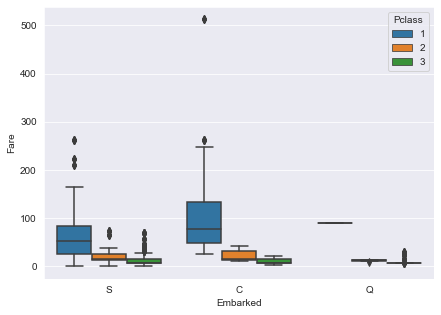

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(7,5))
ax = sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=all_data);



with `Pclass` = 1 and `Fare` = 80, it is more likely to embark at C. Therefore, I will fill the missing values with C 

In [16]:
all_data['Embarked'].fillna("C", inplace=True)

After filling the missing values, this feature is again factorized. 

In [17]:
all_data['Embarked'] = pd.factorize(all_data['Embarked'])[0]

### Fare

there is only one missing value of fare in test_df
see how it is like

In [18]:
all_data[all_data.Fare.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,NaN,3,"Storey, Mr. Thomas",0,60.5,0,0,3701,NaN,NaN,0


`Pclass` = 3 and `Embarked` at 0, from the above figure we can roughly estimate the fare as the mean

In [19]:
## a simpler version 

missing_value_fare = all_data[(all_data.Pclass == 3) & 
                     (all_data.Embarked == 0)].Fare.mean()
## replace the test.fare null values with test.fare mean
all_data.Fare.fillna(missing_value_fare, inplace=True)

## Engineering feature 

Features need to be engineered

1. Cabin: a letter + some number; the letter could be used 
2. Name: mainly use the titles of the names 
3. Ticket: see if there is anything we can use 
4. Age: missing value with ML; see if needed to group them 

Features could be engineered
1. SibSp
2. parch 
<div>
some ideas

    - put into different groups rather than continuous values 
    - put together as family size 

### Cabin 

The naming convention of the `Cabin` is a letter followed by some numbers. People with multiple cabins still have the same letter. So we can just use the first letter as the feature. The `Cabin` is directly associated with class, according to an answer from <a herf="https://www.quora.com/What-were-the-ticket-prices-to-board-the-Titanic">Quora</a>. Therefore, the missing values in `Cabin` can be determined by its fare and class. 

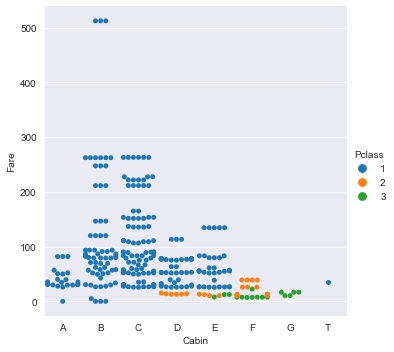

In [20]:
## cabin with values 
all_cabin_nonan = all_data[all_data['Cabin'].notnull()]

all_cabin_nonan['Cabin'] = [i[0] for i in all_cabin_nonan['Cabin']]

all_cabin_nonan = all_cabin_nonan.sort_values(by='Cabin')

sns.catplot(x="Cabin", y="Fare", hue='Pclass', kind="swarm", data=all_cabin_nonan);

From the plot, in each kind, the `Fare` has a large range. To better predict the missing values, here I decide to use bootstrap to generate values. For each `Fare` range and `Pclass` group, the missing `Cabin` value is randomly selected from the known distribution. For example, For `Pclass` = 1 and `Fare` between 200-300, the missing `Cabin` value is chosen from the distribution of values that satisfy this condition. Therefore, I need to decide the group criterion. 

pseudo code:

`if Pclass == 3:
    if Fare > 20:  # this threshold is determined in the following code 
        Cabin = F 
    else: Cabin = random.select from dist of Cabin == E, F, G & Fare < 20 and  Pclass == 3
 if Pclass == 2:
     
    



`
        

In [21]:
## find the threshold from F column
all_cabin_nonan[["Fare","Pclass"]][(all_cabin_nonan["Cabin"]=='F') & (all_cabin_nonan["Pclass"]==3)].max()

Fare      22.3583
Pclass     3.0000
dtype: float64

In [22]:
all_cabin_nonan["Cabin"] = pd.factorize(all_cabin_nonan["Cabin"])[0]

In [23]:
all_cabin_nonan["Cabin"].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [24]:
all_cabin_nan = all_data[all_data['Cabin'].isnull()]

In [25]:
cabin=np.zeros((all_data['Cabin'].isnull().sum(),1))
all_cabin_pclass3 = all_cabin_nonan[all_cabin_nonan["Pclass"] == 3]
all_cabin_pclass2 = all_cabin_nonan[all_cabin_nonan["Pclass"] == 2]
all_cabin_pclass1 = all_cabin_nonan[all_cabin_nonan["Pclass"] == 1]

for i in range(len(cabin)):
    data = all_cabin_nan.iloc[i]
    if data['Pclass'] == 3:
        if data['Fare'] > 20:
            cabin[i] = 5
        else:
            group = all_cabin_pclass3[all_cabin_pclass3['Fare'] <= 20]
            dist = group['Cabin'][(group["Cabin"] >= 3) & (group["Cabin"] <= 5)]
            cabin[i] = np.random.choice(dist)
    elif data['Pclass'] == 2:
        if data['Fare'] > 20:
            cabin[i] = 5
        else:
            group = all_cabin_pclass2[all_cabin_pclass2['Fare'] <= 20]
            dist = group['Cabin'][(group["Cabin"] >= 2) & (group["Cabin"] <= 5)]
            cabin[i] = np.random.choice(dist)
    else:
        if data['Fare'] > 500:
            cabin[i] = 1
        elif data['Fare'] > 200:
            group = all_cabin_pclass1[all_cabin_pclass1['Fare'] > 200]
            dist = group['Cabin'][(group["Cabin"] >= 1) & (group["Cabin"] <= 2)]
            cabin[i] = np.random.choice(dist)
        elif data['Fare'] < 100:
            group = all_cabin_pclass1[all_cabin_pclass1['Fare'] < 100]
            dist = group['Cabin'][(group["Cabin"] >= 0) & (group["Cabin"] <= 4)]
            # cabin T is ignored because there is only one of it -> statistically very small
            cabin[i] = np.random.choice(dist)
        else:
            group = all_cabin_pclass1[(all_cabin_pclass1['Fare'] <= 200) & (all_cabin_pclass1['Fare'] >= 100)]
            dist = group['Cabin'][(group["Cabin"] >= 1) & (group["Cabin"] <= 4)]
            cabin[i] = np.random.choice(dist)

In [26]:
all_cabin_nan['Cabin'] = cabin

all_data = pd.concat([all_cabin_nonan,all_cabin_nan], ignore_index=False) 

all_data['Cabin'] = all_data['Cabin'].astype(int)
# train_df_new = all_data_new[all_data_new['Survived'].notnull()]
# test_df_new = all_data_new[all_data_new['Survived'].isnull()]

In [27]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 96 to 417
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   int64  
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1309 non-null   float64
 9   Cabin     1309 non-null   int32  
 10  Embarked  1309 non-null   int64  
dtypes: float64(3), int32(1), int64(5), object(2)
memory usage: 117.6+ KB


### Name 

For the `Name`, I will extract the title as a new feature and get rid of the `Name` feature.

In [28]:
all_data['Title']=all_data.Name.apply(lambda x: x.split('.')[0].split(',')[1].strip())
all_data['Title'].unique()

array(['Mr', 'Master', 'Sir', 'Dr', 'Miss', 'Mrs', 'Lady', 'Col', 'Mme',
       'Mlle', 'Major', 'Capt', 'the Countess', 'Dona', 'Don', 'Rev',
       'Ms', 'Jonkheer'], dtype=object)

I initially found a method of creating the `Title` with 4 different categories: Mr, Miss, Mrs and Rare, where Rare includes all other different titles such as Dr. Then I realized that simply putting all other titles as `Rare` is ineffective and could impact the accuracy when predicting `Age` as `Age` appears to be associated with titles. Hence I found another way of creating the `Title` where it has more categories from this <a herf="https://medium.com/i-like-big-data-and-i-cannot-lie/how-i-scored-in-the-top-9-of-kaggles-titanic-machine-learning-challenge-243b5f45c8e9">post<a/>.


In [29]:
## this is the first one. 
# all_data_new['Title'] = all_data_new['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
#  	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare') ## simply put all the rare titles in one group is not wise. because the title is important in the Age prediction later! 

# all_data_new['Title'] = all_data_new['Title'].replace('Mlle', 'Miss') # Mlle to Miss
# all_data_new['Title'] = all_data_new['Title'].replace('Ms', 'Miss') # Ms to Miss
# all_data_new['Title'] = all_data_new['Title'].replace('Mme', 'Mrs') # Mme to Mrs
    

In [30]:
# this is the second one. 
newtitles={
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"}

In [31]:
all_data['Title']=all_data.Title.map(newtitles)

In [32]:
## Make sure there is no missing values 
all_data['Title'][all_data['Title'].isnull()]

Series([], Name: Title, dtype: object)

In [33]:
# drop the Name feature and factorize the Title feature 
all_data.drop(['Name'], axis=1, inplace=True)

all_data["Title"] = pd.factorize(all_data["Title"])[0]

### Ticket

I have not yet found an effective approach of dealing with `Ticket`, hence here I choose to drop it. I looked into some discussion posts on kaggle but I think they requires more energy than necessary. 

In [34]:
all_data['Ticket'].describe()

count         1309
unique         929
top       CA. 2343
freq            11
Name: Ticket, dtype: object

In [35]:
ticket = all_data['Ticket']

all_data.drop(['Ticket'], axis=1, inplace=True)

all_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
96,0.0,1,0,71.0,0,0,34.6542,0,1,0
174,0.0,1,0,56.0,0,0,30.6958,0,1,0
806,0.0,1,0,39.0,0,0,0.0000,0,0,0
445,1.0,1,0,4.0,0,2,81.8583,0,0,1
599,1.0,1,0,49.0,1,0,56.9292,0,1,2


### Age 

Because we need to use `Age` as a feature to predict survival rate, `Survival` is not used here to predict age. (not sure if this is correct. But if survival rate is used to predict age and then age is again used to predict survival, wouldn't it be a circulation?)

My first thought is to find out if there is any relation between other features and `Age` by plotting using seaborn. If the distribution of age significantly differs from the feature, this feature is included in the prediction of `Age`. <div>
Features included here are `Sex, Pclass, Cabin, Embarked, Title,` and `Fare`. `SibSp` and `Parch` are not included because there is no direct rational relation among these features. 

In [36]:
features = ['Sex','Pclass','Cabin','Embarked','Title','Fare']

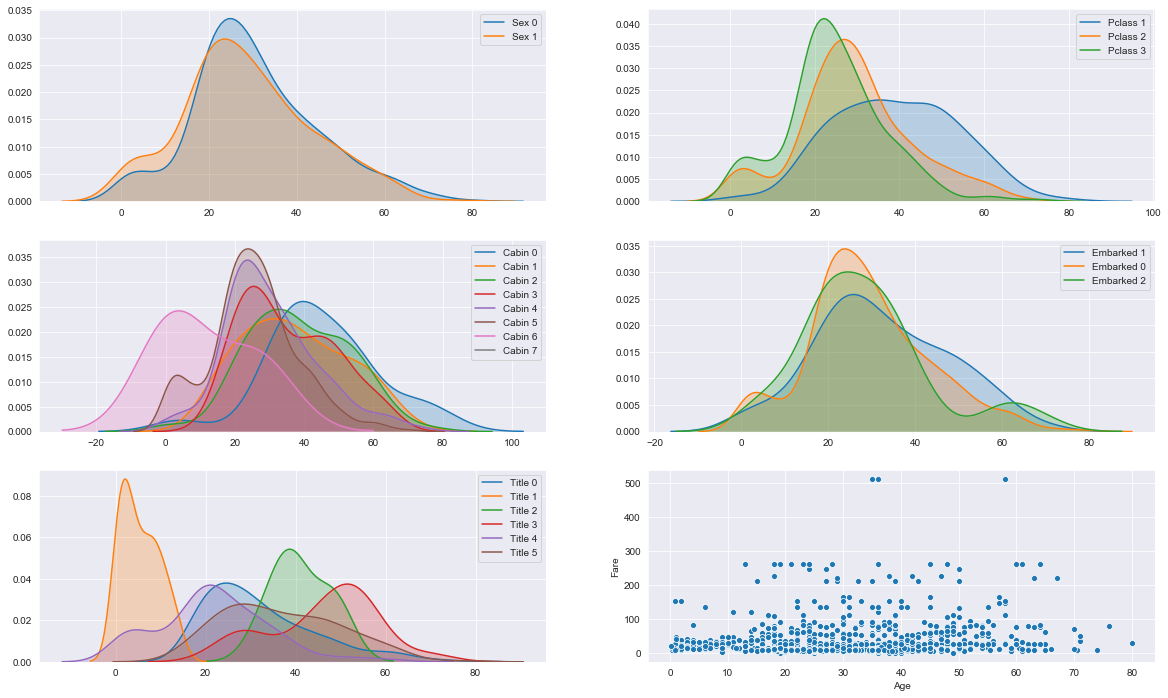

In [37]:
i=0
fig, axes = plt.subplots(ncols=2,nrows=3, figsize=(20,12))
axes = axes.flatten()
for feature in features:
    if feature == 'Fare':
        sns.scatterplot(x='Age', y=feature, data=all_data,legend=False, ax = axes[i])
    else:
        y_axis = all_data[feature].unique()
        for y in y_axis:
            sns.kdeplot(all_data.loc[(all_data[feature] == y),'Age'] , shade=True,label= feature +" "+ str(y), ax = axes[i]);
    #     axes[i].title('Age Distribution '+ feature, fontsize = 25, pad = 40)
    #     axes[i].xlabel("Age", fontsize = 15, labelpad = 20)
    #     axes[i].ylabel('Frequency', fontsize = 15, labelpad= 20);
    i=i+1

From the plot we can see that features including `Pclass, Cabin`, and `Title`. 

However, after some tests, the random forest method is not working that well in the prediction. Then I decide to assign the mean of the `Title` feature to the corresponding missing value. This idea is inspired by this <a herf="https://www.kaggle.com/goldens/titanic-on-the-top-with-a-simple-model"> discussion<a/>.
    

    
    

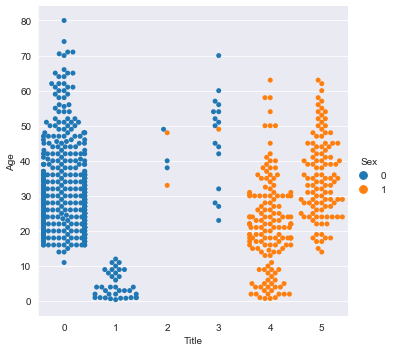

In [38]:
sns.catplot(x="Title", y="Age", hue='Sex', kind="swarm", data=all_data[all_data['Survived'].notnull()]);

In [39]:
age_predict_mean = all_data.groupby(['Title','Sex']).Age.mean()

age_predicts = all_data[all_data.Age.isnull()]

for ind in age_predict_mean.index:
    age_predicts['Age'][(age_predicts['Title'] == ind[0])&(age_predicts['Sex'] == ind[1])] = age_predict_mean.iloc[0]

In [40]:
age_known = all_data[all_data.Age.notnull()]

all_data = pd.concat([age_known,age_predicts], ignore_index=False) 

all_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
96,0.0,1,0,71.0,0,0,34.6542,0,1,0
174,0.0,1,0,56.0,0,0,30.6958,0,1,0
806,0.0,1,0,39.0,0,0,0.0000,0,0,0
445,1.0,1,0,4.0,0,2,81.8583,0,0,1
599,1.0,1,0,49.0,1,0,56.9292,0,1,2


In [41]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 96 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   int64  
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Fare      1309 non-null   float64
 7   Cabin     1309 non-null   int32  
 8   Embarked  1309 non-null   int64  
 9   Title     1309 non-null   int64  
dtypes: float64(3), int32(1), int64(6)
memory usage: 107.4 KB


Now all the features have no missing values except for `Survived`. The rows from `test_df` have no `Survived`. Next I will combine `SibSp` and `Parch` into a new feature as the family size. 

### SibSp & parch

I will first plot the relations to see if it is reasonable to combine these two features. 

In [42]:
# Create a feature called the family size to see if this is relavant 
all_data['FamSiz'] = all_data['Parch'] + all_data['SibSp'] + 1

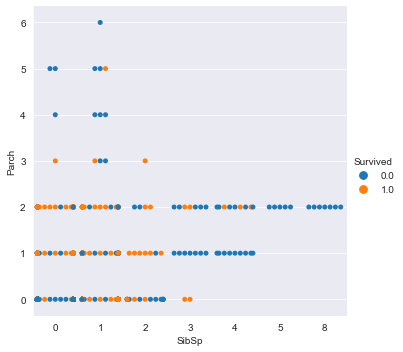

In [43]:
sns.catplot(x="SibSp", y="Parch", hue='Survived', kind="swarm", data=all_data);

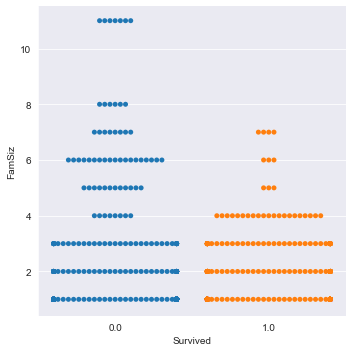

In [44]:
sns.catplot(x="Survived", y="FamSiz", kind="swarm", data=all_data);

The plot on the top does not show obvious groups of `Parch` or `SibSp` with survival. But the bottom plot shows that if you are a family with more than 7 people, judging from the plot, the chance of living is zero. Hence I can create a feature called `FamSiz_7` as familysize=7 

In [45]:
all_data['FamSiz_7'] = (all_data['FamSiz'] > 6).astype(int)

In [46]:
all_data.drop(['FamSiz'], axis=1, inplace=True)

all_data.drop(['SibSp','Parch'],axis=1,inplace=True)

all_data.tail()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamSiz_7
408,NaN,3,1,32.252151,7.7208,5,2,4,0
410,NaN,3,1,32.252151,7.7500,5,2,4,0
413,NaN,3,0,32.252151,8.0500,5,0,0,0
416,NaN,3,0,32.252151,8.0500,4,0,0,0
417,NaN,3,0,32.252151,22.3583,5,1,1,0


In [47]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 96 to 417
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   int64  
 3   Age       1309 non-null   float64
 4   Fare      1309 non-null   float64
 5   Cabin     1309 non-null   int32  
 6   Embarked  1309 non-null   int64  
 7   Title     1309 non-null   int64  
 8   FamSiz_7  1309 non-null   int32  
dtypes: float64(3), int32(2), int64(4)
memory usage: 132.0 KB


## Clean up the data (get dummies)

In [48]:
# create dummy variables for categorical features
pclass_dummies = pd.get_dummies(all_data.Pclass, prefix="Pclass")
title_dummies = pd.get_dummies(all_data.Title, prefix="Title")
cabin_dummies = pd.get_dummies(all_data.Cabin, prefix="Cabin")
embarked_dummies = pd.get_dummies(all_data.Embarked, prefix="Embarked")

# concatenate dummy columns with main dataset
all_data_dummies = pd.concat([all_data, pclass_dummies, title_dummies, cabin_dummies, embarked_dummies], axis=1)

# drop categorical fields
all_data_dummies.drop(['Pclass', 'Title', 'Cabin', 'Embarked'], axis=1, inplace=True)

all_data_dummies.columns

Index(['Survived', 'Sex', 'Age', 'Fare', 'FamSiz_7', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Title_0', 'Title_1', 'Title_2', 'Title_3', 'Title_4',
       'Title_5', 'Cabin_0', 'Cabin_1', 'Cabin_2', 'Cabin_3', 'Cabin_4',
       'Cabin_5', 'Cabin_6', 'Cabin_7', 'Embarked_0', 'Embarked_1',
       'Embarked_2'],
      dtype='object')

In [49]:
all_data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 96 to 417
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Sex         1309 non-null   int64  
 2   Age         1309 non-null   float64
 3   Fare        1309 non-null   float64
 4   FamSiz_7    1309 non-null   int32  
 5   Pclass_1    1309 non-null   uint8  
 6   Pclass_2    1309 non-null   uint8  
 7   Pclass_3    1309 non-null   uint8  
 8   Title_0     1309 non-null   uint8  
 9   Title_1     1309 non-null   uint8  
 10  Title_2     1309 non-null   uint8  
 11  Title_3     1309 non-null   uint8  
 12  Title_4     1309 non-null   uint8  
 13  Title_5     1309 non-null   uint8  
 14  Cabin_0     1309 non-null   uint8  
 15  Cabin_1     1309 non-null   uint8  
 16  Cabin_2     1309 non-null   uint8  
 17  Cabin_3     1309 non-null   uint8  
 18  Cabin_4     1309 non-null   uint8  
 19  Cabin_5     1309 non-null  

# Model training

For the model training, I adopted four different methods
    - decision tree
    - kNN
    - random forest
    - logstic regression 

The following codes are based applications of these four methods. 

In [50]:
# make sure the train data and test data are correct in length 
print(all_data.Survived.notnull().sum())
print(all_data.Survived.isnull().sum())

891
418


In [51]:
train_data = all_data[all_data.Survived.notnull()]
test_data = all_data[all_data.Survived.isnull()]
y = train_data['Survived']
train_data.drop(['Survived'],axis=1,inplace=True)
test_data.drop(['Survived'],axis=1,inplace=True)

In [52]:
test_data.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamSiz_7
293,1,0,53.0,81.8583,0,0,3,0
331,1,0,39.0,29.7000,0,1,0,0
28,1,0,41.0,30.5000,0,0,0,0
208,1,1,33.0,27.7208,0,1,4,0
46,1,0,45.0,29.7000,0,1,0,0


In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
scaler = StandardScaler()
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [54]:
## create train data and dev data 
X_train, X_holdout, y_train, y_holdout = train_test_split(train_data.values, y, test_size=0.3,
random_state=17)

## Decision tree

In [55]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)


tree_params = {'max_depth': range(2,7),
               'max_features': range(2,15)}

tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1, verbose=True) 

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 65 candidates, totalling 325 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 325 out of 325 | elapsed:    1.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=17,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(2, 7),
                         'max_feat

## kNN

In [56]:
# for kNN, we need to scale features
knn = KNeighborsClassifier(n_neighbors=7)
scaler = StandardScaler()  
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])
knn_params = {'knn__n_neighbors': range(1, 10)}
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)
knn_grid.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=-1,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             

## Random forest

In [57]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
forest_params = {'max_depth': range(2,12),
                 'max_features': range(2,12)}

forest_grid = GridSearchCV(forest, forest_params,
                           cv=5, n_jobs=-1, verbose=True)

forest_grid.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   37.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=17,
                                    

## Logistic regression 

In [58]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_grid=GridSearchCV(logreg,grid,cv=10)
logreg_grid.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

## Determine the best method

The most appropriate method is the one with the highest dev score 

In [59]:
dev_score = [accuracy_score(y_holdout, tree_grid.predict(X_holdout)),
             accuracy_score(y_holdout, knn_grid.predict(X_holdout)),
             accuracy_score(y_holdout, forest_grid.predict(X_holdout)),
             accuracy_score(y_holdout, logreg_grid.predict(X_holdout)),]

In [60]:
print('Decision Tree:')
# print('best parameters: ',tree_grid.best_params_) #{'max_depth': 6, 'max_features': 17}
print('best score: ',tree_grid.best_score_ )
print('Dev score: ',accuracy_score(y_holdout, tree_grid.predict(X_holdout)))
print('kNN:')
# print('best parameters: ',knn_grid.best_params_) #{'max_depth': 6, 'max_features': 17}
print('best score: ',knn_grid.best_score_ )
print('Dev score: ',accuracy_score(y_holdout, knn_grid.predict(X_holdout)))
print('Random Forest:')
# print('best parameters: ',forest_grid.best_params_) #{'max_depth': 6, 'max_features': 17}
print('best score: ',forest_grid.best_score_ )
print('Dev score: ',accuracy_score(y_holdout, forest_grid.predict(X_holdout)))
print('Logistic Regression:')
# print('best parameters: ',forest_grid.best_params_) #{'max_depth': 6, 'max_features': 17}
print('best score: ',logreg_grid.best_score_ )
print('Dev score: ',accuracy_score(y_holdout, logreg_grid.predict(X_holdout)))

Decision Tree:
best score:  0.8154064516129033
Dev score:  0.8507462686567164
kNN:
best score:  0.7897548387096774
Dev score:  0.7910447761194029
Random Forest:
best score:  0.8202064516129033
Dev score:  0.8395522388059702
Logistic Regression:
best score:  0.7865079365079365
Dev score:  0.8208955223880597


Here we can see that decision tree gives the highest score. So I will use this model for prediction. 

## Prediction

In [61]:
test_survive = tree_grid.predict(test_data)
test_data['Survive'] = test_survive

In [62]:
test_data = test_data.sort_index()

In [63]:
output = pd.DataFrame({'PassengerId': PassengerId, 'Survived': test_data['Survive'].astype(int)})
output.to_csv('my_submission_v9.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


This prediction gives 78% accuracy. 